# Поиск изображений по текстовому описанию

**Описание проекта** \
Фотохостинг для профессиональных фотографов «Со Смыслом» (“With Sense”) планирует запустить поиск изображений по текстовому описанию (сцены/сюжета). Для защиты проекта перед руководством требуется подготовка PoC(proof of concept), демонстрирующий практическую осуществимость. В проекте предусмотрены юридические ограничения по возрасту людей на изображениях.

**Цель** \
Сравним результаты работы полученной ранее модели классификации на базе полносвязной нейронной сети с предобученной нейросетью CLIP (Contrastive Language-Image Pre-trained). Рассчитаем целевую метрику и проведем качественную оценку работы CLIP на описаниях из тестовой выборки.


In [11]:
import os
import sys
import re
import pickle
from typing import Set

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

import torch
from transformers import CLIPModel, CLIPProcessor

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_STATE = 42
CLIP_NAME = 'openai/clip-vit-base-patch32'

PATH = Path.cwd() / 'to_upload'

# --- стоп-слова ---
BAD_TERMS = {
    'baby', 'babies', 'newborn', 'infant', 'toddler',
    'child', 'children', 'kid', 'kids',
    'boy', 'boys', 'girl', 'girls',
    'schoolboy', 'schoolgirl', 'pupil',
    'teen', 'teenage', 'teenager', 'teenagers',
    'preschooler', 'kindergartner', 'kindergarten', 'junior', 'youth'
}

print('Импорты/настройки/данные готовы.')


Импорты/настройки/данные готовы.


## Использование модели CLIP от OPEN AI

Сравним результаты работы полученной ранее модели (ноутбук "01_Model_development.ipynb") с предобученной нейросетью CLIP (Contrastive Language-Image Pre-trained). CLIP предобучалась на огромном по размеру датасете пар изображение-текст и способна понимать не просто общую "тематику" изображения (собаки, кошки, люди и т.п.), как это делал наш классификатор, а полностью улавливать весь контекст. Доп.обучение при этом не требуется, нам необходимо только векторизовать наши данные с помощью встроенных инструментов CLIP.

Инициализируем модель через transformer.

In [2]:
clip_model = CLIPModel.from_pretrained(CLIP_NAME).to(device).eval()
clip_processor = CLIPProcessor.from_pretrained(CLIP_NAME)

Т.к. у CLIP свой встроенный метод векторизации, поэтому повторим заново весь процесс для текста и изображений. 

Начнем с изображений. Важно учесть, что CLIPProcessor возвращает словарь, а не тензор как это было с ResNet, поэтому немного модифицируем предыдущую функцию для получения веекторов изображений.

In [3]:
@torch.no_grad()
def embed_images_iter_clip(root, names, processor, model, device='cpu'):
    '''
    Функция читает каждое изображение, прогоняет через CLIP и возвращает:
    - kept: список имён файлов (kept) и матрицу матрицу эмбеддингов (N, 512)
    '''
    model.eval()
    vecs, kept = [], []

    for name in tqdm(names, total=len(names), desc='Embedding images (CLIP)'):
        p = Path(root) / name
        img = Image.open(p).convert('RGB')

        inputs = processor(images=img, return_tensors='pt').to(device)

        z = model.get_image_features(**inputs) 

        vecs.append(z.squeeze(0).cpu().numpy())
        kept.append(name)

    return kept, np.stack(vecs, axis=0)


In [6]:
train_root = PATH / 'train_images'
train_names = sorted([p.name for p in (train_root).glob("*.jpg")])

test_root = PATH / 'test_images'
test_names = sorted([p.name for p in (test_root).glob("*.jpg")])

train_names_clip, train_vecs_clip = embed_images_iter_clip(train_root, train_names, clip_processor, clip_model, device)
test_names_clip, test_vecs_clip = embed_images_iter_clip(test_root, test_names, clip_processor, clip_model, device)

emb_train_img_clip = pd.DataFrame(train_vecs_clip, index=train_names_clip).reset_index().rename(columns={'index':'image'})
emb_test_img_clip  = pd.DataFrame(test_vecs_clip,  index=test_names_clip ).reset_index().rename(columns={'index':'image'})

print(emb_train_img_clip.shape, emb_test_img_clip.shape)
display(emb_train_img_clip.head(2))

Embedding images (CLIP):   0%|          | 0/1000 [00:00<?, ?it/s]

Embedding images (CLIP):   0%|          | 0/100 [00:00<?, ?it/s]

(1000, 513) (100, 513)


image         0         1         2         3  \
0  1056338697_4f7d7ce270.jpg  0.529711  0.507866 -0.014296  0.005955   
1   106490881_5a2dd9b7bd.jpg  0.260149  0.190995 -0.258447  0.007751   

          4         5         6         7         8  ...       502       503  \
0 -0.178848  0.089191  0.579242  0.299036  0.644132  ... -0.541030  0.323624   
1  0.225401 -0.174339  0.004886 -0.055314  0.244780  ...  0.039981  0.510883   

        504       505       506       507       508       509       510  \
0  0.146667  0.251089  0.382325 -0.342547 -0.763859  0.637885 -0.401777   
1  0.117329 -0.104438  0.324582  0.013884 -0.874795  0.641889  0.211970   

        511  
0 -0.233480  
1  0.141342  

[2 rows x 513 columns]

Векторизуем текст также с помощью инструментов CLIP.

In [7]:
train_clean = pd.read_csv('train_clean.csv', index_col=0)
text_train = train_clean[['image','query_id','query_text']].copy()
text_train.head(2)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...

In [8]:
@torch.no_grad()
def clip_embed_texts(texts, processor, model, device, batch_size):
    """
    Считает CLIP-эмбеддинги для списка текстов.
    Возвращает матрицу (N, 512)
    """
    model.eval()
    vecs = []

    for i in tqdm(range(0, len(texts), batch_size), desc='Embedding texts (CLIP)'):
        batch = texts[i:i+batch_size]

        inputs = processor(
            text=batch,
            return_tensors='pt',
            padding=True,
            truncation=True
        ).to(device)

        text_emb = model.get_text_features(**inputs)              

        vecs.append(text_emb.cpu().numpy().astype('float32'))

    return np.vstack(vecs)

In [9]:
train_vecs_clip = clip_embed_texts(text_train['query_text'].tolist(),
                                   clip_processor,
                                   clip_model,
                                   device, batch_size=256
                                   )
print('train_vecs_clip:', train_vecs_clip.shape)

emb_text_train_clip = pd.DataFrame(train_vecs_clip, columns=[f'clip_text_{i}' for i in range(train_vecs_clip.shape[1])])
emb_text_train_clip.insert(0, 'query_id', text_train['query_id'].values)
emb_text_train_clip.insert(1, 'image', text_train['image'].values)

Embedding texts (CLIP):   0%|          | 0/19 [00:00<?, ?it/s]

train_vecs_clip: (4695, 512)


Для корректного сравнения метрики повторим масштабирование (нормализацию) векторов для изображений и текста.

In [12]:
normalizer_img_clip = Normalizer(norm='l2')

img_feat_cols_train_clip = [col for col in emb_train_img_clip.columns if col != 'image']
img_feat_cols_test_clip  = [col for col in emb_test_img_clip.columns  if col != 'image']

emb_train_img_clip[img_feat_cols_train_clip] = normalizer_img_clip.fit_transform(
    emb_train_img_clip[img_feat_cols_train_clip]
)
emb_test_img_clip[img_feat_cols_test_clip] = normalizer_img_clip.transform(
    emb_test_img_clip[img_feat_cols_test_clip]
)


In [13]:
normalizer_text_clip = Normalizer(norm='l2')

text_feat_cols_train_clip = [col for col in emb_text_train_clip.columns if col not in ['image', 'query_id']]

emb_text_train_clip[text_feat_cols_train_clip] = normalizer_text_clip.fit_transform(
    emb_text_train_clip[text_feat_cols_train_clip]
)

Объединим обучающий датасет.

In [14]:
emb_train_df_clip = emb_train_img_clip.add_prefix('clip_img_').rename(columns={'clip_img_image':'image'})
emb_test_df_clip  = emb_test_img_clip.add_prefix('clip_img_').rename(columns={'clip_img_image':'image'})

print('Размер до объединения:', train_clean.shape)
df_model_clip = (train_clean[['image', 'query_id', 'target']]
              .merge(emb_train_df_clip, on='image', how='left')
              .merge(emb_text_train_clip, on=['image', 'query_id'], how='left'))
print('Размер после объединения:', df_model_clip.shape)
df_model_clip.head()

Размер до объединения: (4695, 9)
Размер после объединения: (4695, 1027)


image                     query_id  target  clip_img_0  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.0    0.045367   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2     0.0    0.000832   
2  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2     0.0   -0.000358   
3  3155451946_c0862c70cb.jpg  2549968784_39bfbe44f9.jpg#2     0.0   -0.019611   
4  3222041930_f642f49d28.jpg  2549968784_39bfbe44f9.jpg#2     0.0   -0.035046   

   clip_img_1  clip_img_2  clip_img_3  clip_img_4  clip_img_5  clip_img_6  \
0    0.043496   -0.001224    0.000510   -0.015317    0.007639    0.049609   
1    0.062394   -0.000397    0.055692    0.030966   -0.021432    0.001914   
2    0.012194   -0.001064    0.023898    0.059350    0.030268    0.001926   
3    0.035012    0.043793   -0.007710    0.018386    0.072150    0.013157   
4    0.043626    0.020196   -0.024195    0.039991    0.009842    0.023717   

   ...  clip_text_502  clip_text_503  clip_text_504  clip_text_505  \
0  ...      -0.034126       0.072126       0.040707      -0.048389   
1  ...      -0.034126       0.072126       0.040707      -0.048389   
2  ...      -0.034126       0.072126       0.040707      -0.048389   
3  ...      -0.034126       0.072126       0.040707      -0.048389   
4  ...      -0.034126       0.072126       0.040707      -0.048389   

   clip_text_506  clip_text_507  clip_text_508  clip_text_509  clip_text_510  \
0      -0.033506      -0.017856       0.026729       0.017854       0.032808   
1      -0.033506      -0.017856       0.026729       0.017854       0.032808   
2      -0.033506      -0.017856       0.026729       0.017854       0.032808   
3      -0.033506      -0.017856       0.026729       0.017854       0.032808   
4      -0.033506      -0.017856       0.026729       0.017854       0.032808   

   clip_text_511  
0      -0.039688  
1      -0.039688  
2      -0.039688  
3      -0.039688  
4      -0.039688  

[5 rows x 1027 columns]

Рассчитаем целевую метрику для той же валидационной выборки. 

Для расчета MSE нам необходимо получить предсказания модели. В случае с CLIP для этой цели мы получаем zero-shot score, т.е. мы берем предобученную модель, никак дополнительно не настраивая ее веса, и рассчитываем косинусное сходство между векторами - это и будут наши предсказания. А затем по этим предсказаниям считаем MSE как обычно.

Для начала разделим колонки по признаку текст/изображение и получим матрицы эмбеддингов для расчетов.

In [15]:
img_cols_clip  = [c for c in df_model_clip.columns if c.startswith('clip_img_')]
text_cols_clip = [c for c in df_model_clip.columns if c.startswith('clip_text_')]

img_mat_clip  = df_model_clip[img_cols_clip].to_numpy(dtype='float32')
text_mat_clip = df_model_clip[text_cols_clip].to_numpy(dtype='float32')


Рассчитаем zero-shot score для каждой строки, а затем рассчитаем MSE на той же валидационной выборке, используя ранее сохраненные индексы (`val_indices`).

In [16]:
with open('split_indices.pkl', 'rb') as f:
    indices = pickle.load(f)
    train_indices = indices['train_indices']
    val_indices = indices['val_indices']

In [17]:
clip_scores = (img_mat_clip * text_mat_clip).sum(axis=1)  
df_model_clip['clip_score'] = clip_scores

clip_val = clip_scores[val_indices] 
y_val = df_model_clip['target'].iloc[val_indices]
mse_clip = mean_squared_error(y_val, clip_val)
print('MSE на валидационной выборке для модели CLIP:', mse_clip)

MSE на валидационной выборке для модели CLIP: 0.056325750672461185


По результатам сравнения видно, что **Zero-shot CLIP** без какого-либо дообучения на данных даёт **MSE ≈ 0.0563** — то есть работает примерно на уровне лучших бустинговых моделей. При этом по метрике полносвязная нейросеть дала лучший результат (**MSE = 0.0476**). 

Оценим визуально раоту модели CLIP на тестовой выборке. Для этого внесем небольшие правки исходную функцию `get_picture`, чтобы учесть особенности предобработки текста для этой модели и расчет предсказаний (скоров). Остальное оставим без изменений.

In [18]:
img_feat_cols_clip = [col for col in emb_test_img_clip.columns if col != 'image']
IMG_EMB_CLIP = emb_test_img_clip[img_feat_cols_clip].to_numpy(dtype='float32')
IMG_NAMES_CLIP = emb_test_img_clip['image'].tolist()


In [19]:
def is_child_text(text: str, terms: Set[str] = BAD_TERMS):
    '''
    Функция определяет, относится ли текст к детскому контенту по набору стоп-слов.

    Параметры
    ---------
    text : str
        Описание изображения.
    terms : set of str
        Множество стоп-слов, по которым определяется детский контент.
    '''
    s = str(text).lower()
    tokens = re.findall(r"[a-z]+(?:-[a-z]+)?", s)
    bag = set(tokens)
    bad_hit = terms.intersection(bag)
    if bad_hit:
        return True, 'stop-word:' + '/'.join(sorted(bad_hit))
    return False, ''

In [20]:
def get_picture_clip(text):
    flag_child, _ = is_child_text(text)
    if flag_child:
        print('\n' + '-' * 20, text, '-' * 20 + '\n')
        print('This image is unavailable in your country in compliance with local laws.\n')
        return

    text_vec = clip_embed_texts(
        [text],
        processor=clip_processor,
        model=clip_model,
        device=device,
        batch_size=1
    ) 

    text_vec_df = pd.DataFrame(
        text_vec,
        columns=text_feat_cols_train_clip 
    )
    text_vec_norm = normalizer_text_clip.transform(text_vec_df).astype('float32') 

    scores = IMG_EMB_CLIP @ text_vec_norm[0]

    top_idx = np.argsort(scores)[::-1][:5]
    top = [IMG_NAMES_CLIP[i] for i in top_idx]
    top_score = [scores[i] for i in top_idx]

    print('\n' + '-' * 20, text, '-' * 20 + '\n')
    fig = plt.figure(figsize=(15, 5))
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0

    for i in range(5):
        ax = fig.add_subplot(1, 6, i + 1, title=round(float(top_score[i]), 3))
        image = Image.open(Path(PATH, 'test_images', top[i])).convert("RGB")
        ax.imshow(image)
        plt.xticks([]); plt.yticks([])
        plt.tight_layout()

    plt.show()
    return None


Для корректного сравнения возьмем те же описания, что и при тестировании обученной модели классификации.

In [21]:
text_test_sample = ['A Yorkie trying to catch a red toy .',
 'Three riders wearing black jerseys jump their BMX bikes into the air .',
 'a tan dog wearing a multicolored color running on the beach',
 'A little white dog in running on the sidewalk .',
 'Two women in head wraps .',
 'A white dog with brown ears is running on the sidewalk .',
 'A group of friends play instruments in the middle of the woods .',
 'Four people playing basketball on wooden area near the beach .',
 'A tan dog runs through the brush .',
 'Three men on mountain bikes go over a sand hill .']

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- A Yorkie trying to catch a red toy . --------------------



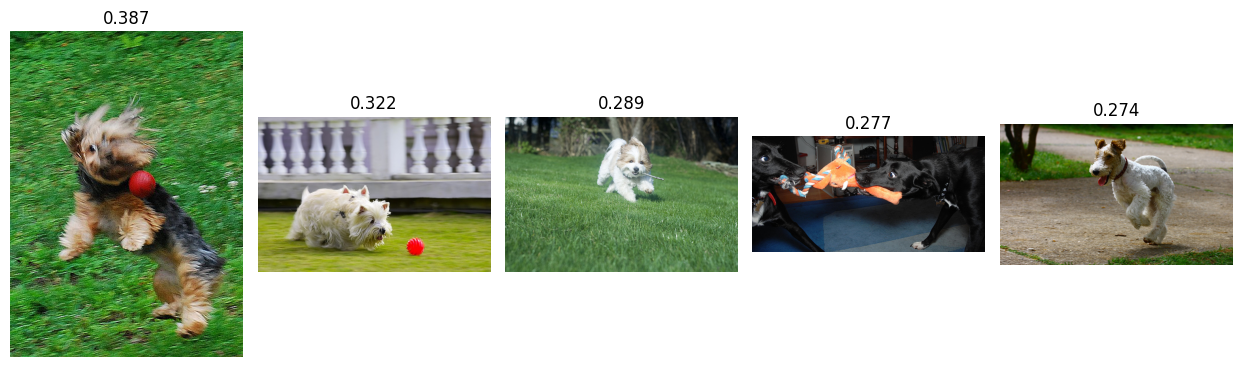

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- Three riders wearing black jerseys jump their BMX bikes into the air . --------------------



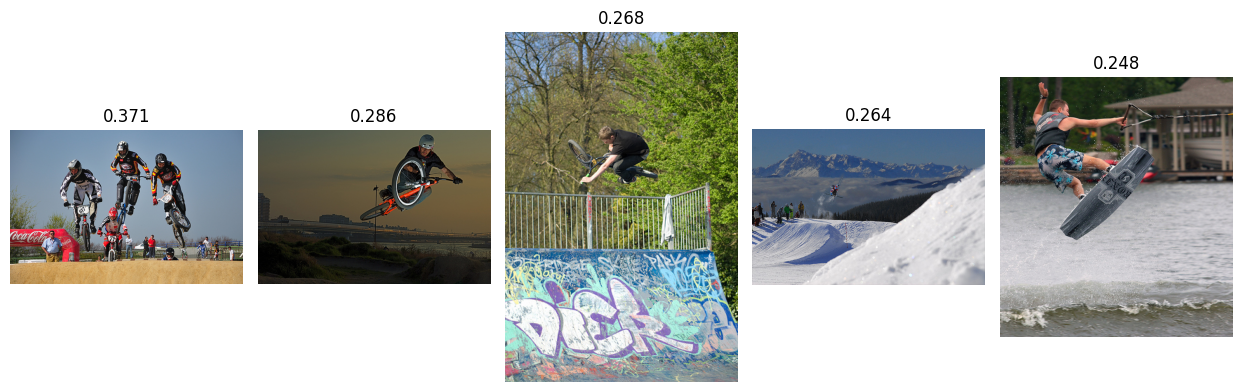

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- a tan dog wearing a multicolored color running on the beach --------------------



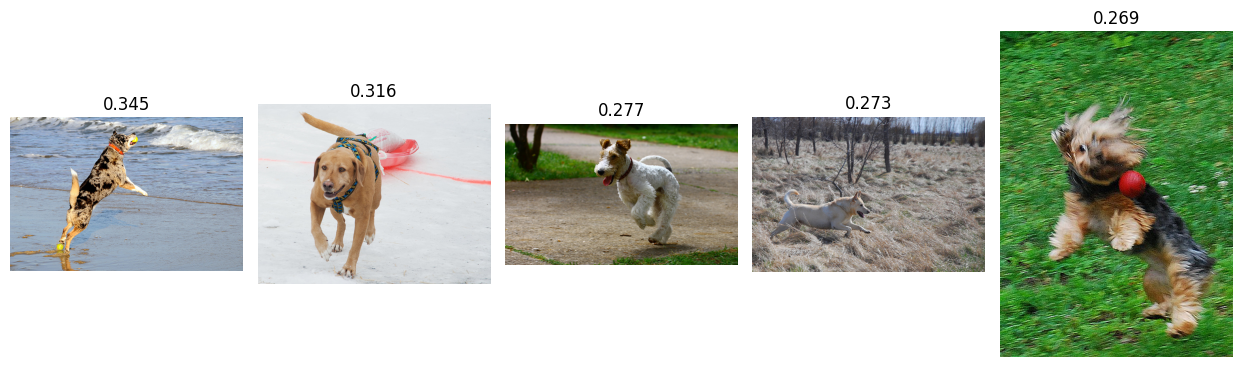

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- A little white dog in running on the sidewalk . --------------------



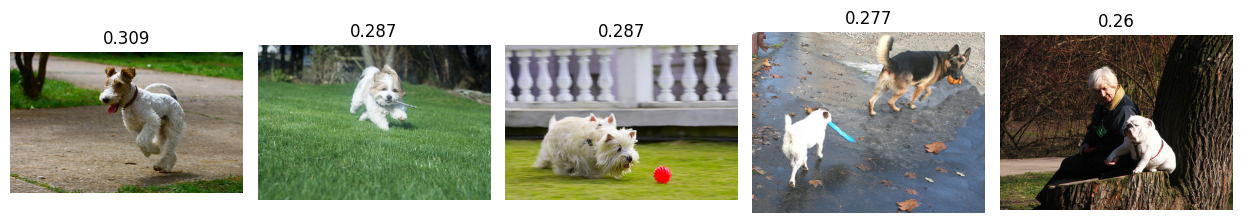

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- Two women in head wraps . --------------------



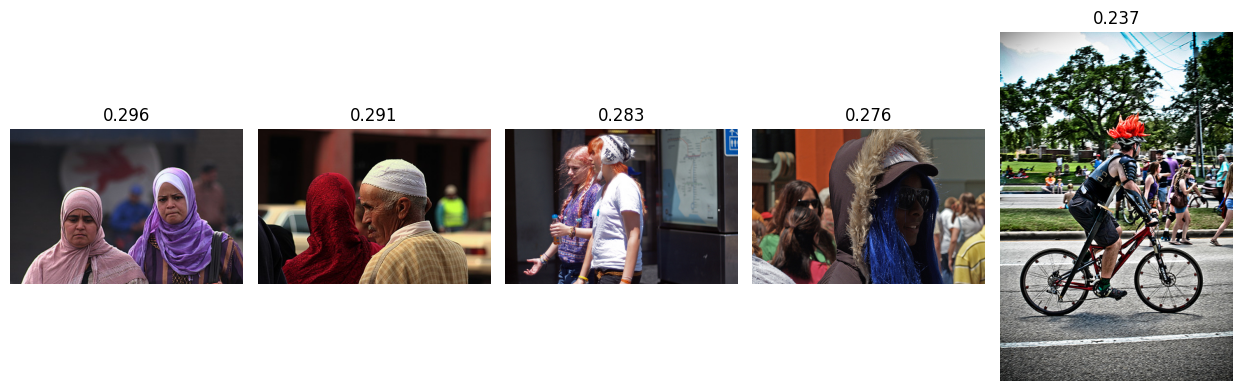

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- A white dog with brown ears is running on the sidewalk . --------------------



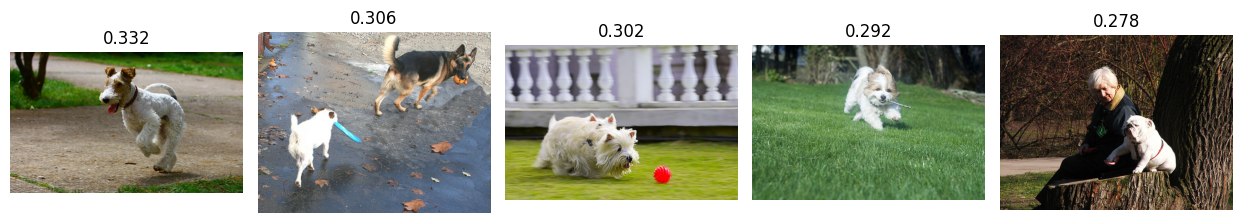

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- A group of friends play instruments in the middle of the woods . --------------------



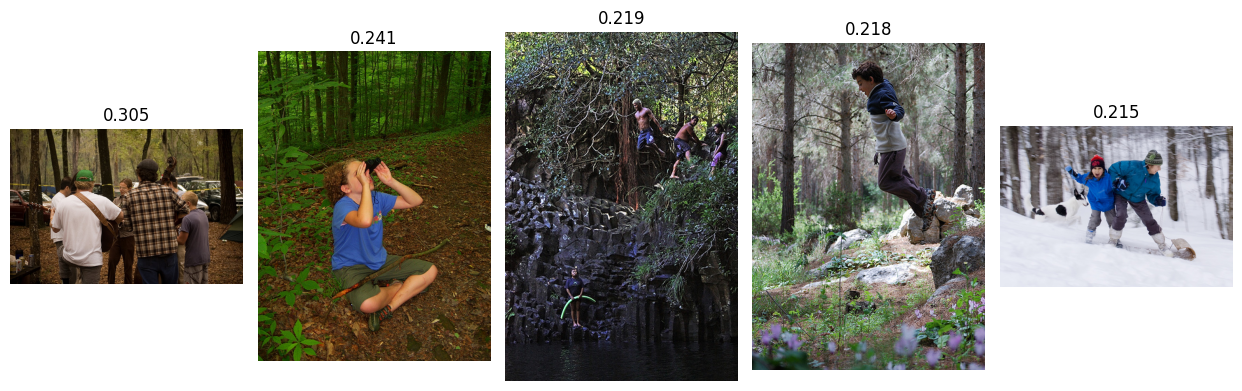

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- Four people playing basketball on wooden area near the beach . --------------------



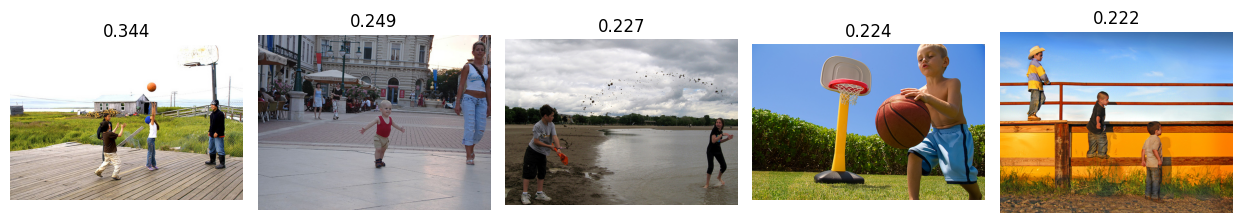

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- A tan dog runs through the brush . --------------------



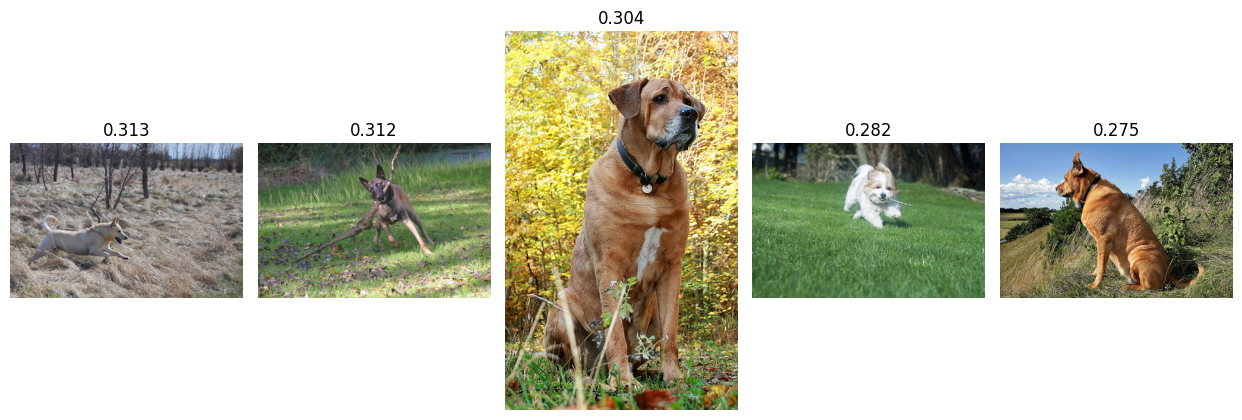

Embedding texts (CLIP):   0%|          | 0/1 [00:00<?, ?it/s]


-------------------- Three men on mountain bikes go over a sand hill . --------------------



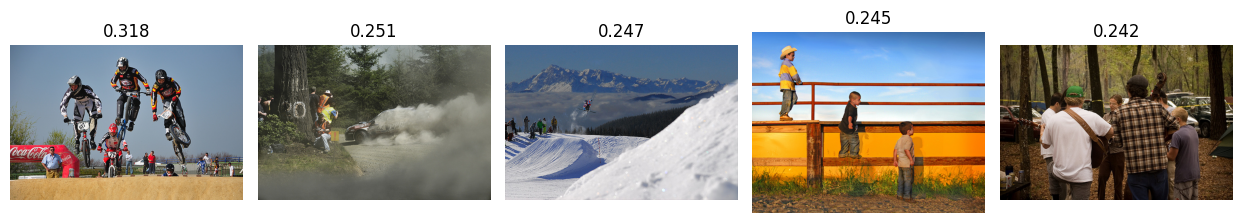

In [22]:
for text in text_test_sample:
    get_picture_clip(text)

<b>Вывод по разделу "Использование модели CLIP от OPEN AI"</b>

Визульная оценка результатов работы модели CLIP показала, что модель даёт более точный подбор картинок к тексту, тогда как **полносвязная нейросеть** чаще давала более "шумные" результаты, подходящие только по общей тематике, несмотря на то, что по MSE она выигрывает на валидации.

Полносвязная нейросеть заметно цепляется за фон/общую обстановку (собаки, мотоциклы, люди), но хуже удерживает точный семантический смысл подписи. CLIP дает более осмысленный и «человеческий» подбор картинок, более того модель точно угадала исходную картинку по подписи. Таким образом, использование CLIP приоритетно при решении этой задачи.

## Выводы

1. При обучении моделей лучший результат показала **полносвязная нейронная сеть**, обученная на объединённых эмбеддингах изображения (ResNet-50) и текста (all-MiniLM-L6-v2). **Качество:** MSE = **0.0476**.  

2. В этом ноутбуке была дополнительно протестирована предобученная мультимодальная модель **CLIP** в zero-shot режиме (без дообучения на данных задачи).  
На той же валидации **CLIP (zero-shot)** показывает **MSE ≈ 0.0563**, то есть работает на уровне лучших классических моделей, но при этом не требует обучения. По чистой метрике MSE он уступает дообученной полносвязной нейросети.

3. **Подбор изображений по описанию (качественный анализ)**

- **CLIP** даёт более «человеческий» подбор: выданные изображения хорошо соответствуют контексту описания, в топ-результаты часто попадают оригинальные изображения, наиболее точно совпадающие с текстом.
- Обученная **полносвязная нейросеть** чаще даёт шумные результаты: модель правильно улавливает общий фон (животные, люди, велосипеды и т.п.), но хуже попадает в точную ситуацию и взаимодействие объектов. Тем не менее, с учётом небольшого размера обучающего датасета полученный результат можно считать неплохим.

4. **Оценка реализуемости сервиса**

Базовый сервис поиска фотографий по текстовому описанию **реалистичен**: для простых пользовательских запросов и полносвязная нейросеть, и CLIP возвращают осмысленные, визуально релевантные результаты.

**Ограничения:**
- Для достижения высокого уровня точности при самостоятельном обучении классификатора понадобится более сложная архитектура и существенно больший объём обучающих данных и вычислительных ресурсов.
- С точки зрения финансовой и инженерной целесообразности разумнее опираться на предобученный **CLIP**, который уже хорошо улавливает контекст описания в zero-shot режиме.

Перспективное направление развития — попробовать ансамбль из **CLIP** и дообученной «головы» (например, дополнительного линейного слоя или небольшой MLP), чтобы совмещать сильные стороны предобученной модели и адаптации под конкретную задачу.
